In [1]:
#Facebook's Prophet library already included in Colab
#!pip install fbprophet
#Install World Weather Online library and import other dependencies:
#!pip install wwo-hist
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from datetime import datetime, timedelta
import requests
from wwo_hist import retrieve_hist_data
from datetime import date
import pytz
%matplotlib inline

In [2]:
#Import our visit data from an excel file on Dropbox
df = pd.read_excel('daily-visits-incl-20-01-11.xlsx')
#Prophet only accepts these columns names:
df.columns = ['ds','y']
#Some of the timestamp day occasionally is off by a few milliseconds, not sure why, but we'll fix it by rounding:
df['ds'] = df['ds'].dt.round('15min')
#I've saved the data as hourly visits, so to convert to daily visits we group by date:
#df = df.groupby([df['ds'].dt.date]).sum()
#df = df.reset_index()
df = df.dropna()
df.tail()

,ds,y
66678,2020-01-11 16:00:00,9
66679,2020-01-11 17:00:00,7
66680,2020-01-11 18:00:00,3
66681,2020-01-11 19:00:00,4
66682,2020-01-11 20:00:00,1


In [3]:
stat_days_df = pd.read_excel('https://www.dropbox.com/s/6kv67yhuv6f3b3h/statdays.xlsx?dl=1')
print(stat_days_df.head())
ramq_stat_days = stat_days_df['RAMQ']
ramq_stat_days = ramq_stat_days.dropna()
ramq_stat_days_with_hours = []
for stat_day in ramq_stat_days:
  for hour in range(24):
    ramq_stat_days_with_hours.append(stat_day + timedelta(hours=hour))
print(ramq_stat_days_with_hours)
ramq_stat_days_with_hours
jgh_stat_days = stat_days_df['JGH']
jgh_stat_days = jgh_stat_days.dropna()
jgh_stat_days_with_hours = []
for stat_day in jgh_stat_days:
  for hour in range(24):
    jgh_stat_days_with_hours.append(stat_day + timedelta(hours=hour))
print(jgh_stat_days_with_hours)

        RAMQ        JGH
0 2015-05-18 2015-05-18
1 2015-06-24 2015-06-24
2 2015-07-01 2015-07-01
3 2015-09-07 2015-09-07
4 2015-10-12 2015-10-12
[Timestamp('2015-05-18 00:00:00'), Timestamp('2015-05-18 01:00:00'), Timestamp('2015-05-18 02:00:00'), Timestamp('2015-05-18 03:00:00'), Timestamp('2015-05-18 04:00:00'), Timestamp('2015-05-18 05:00:00'), Timestamp('2015-05-18 06:00:00'), Timestamp('2015-05-18 07:00:00'), Timestamp('2015-05-18 08:00:00'), Timestamp('2015-05-18 09:00:00'), Timestamp('2015-05-18 10:00:00'), Timestamp('2015-05-18 11:00:00'), Timestamp('2015-05-18 12:00:00'), Timestamp('2015-05-18 13:00:00'), Timestamp('2015-05-18 14:00:00'), Timestamp('2015-05-18 15:00:00'), Timestamp('2015-05-18 16:00:00'), Timestamp('2015-05-18 17:00:00'), Timestamp('2015-05-18 18:00:00'), Timestamp('2015-05-18 19:00:00'), Timestamp('2015-05-18 20:00:00'), Timestamp('2015-05-18 21:00:00'), Timestamp('2015-05-18 22:00:00'), Timestamp('2015-05-18 23:00:00'), Timestamp('2015-06-24 00:00:00'), Times

In [4]:
ramq_stat_days = pd.DataFrame({
  'holiday': 'ramq',
  'ds': ramq_stat_days_with_hours,
  'lower_window': 0,
  'upper_window': 1,
})
print(ramq_stat_days.head())
jgh_stat_days = pd.DataFrame({
  'holiday': 'jgh',
  'ds': jgh_stat_days_with_hours,
  'lower_window': 0,
  'upper_window': 1,
})
print(jgh_stat_days.head())
holidays = pd.concat((ramq_stat_days, jgh_stat_days))
print(holidays.sample(10))

  holiday                  ds  lower_window  upper_window
0    ramq 2015-05-18 00:00:00             0             1
1    ramq 2015-05-18 01:00:00             0             1
2    ramq 2015-05-18 02:00:00             0             1
3    ramq 2015-05-18 03:00:00             0             1
4    ramq 2015-05-18 04:00:00             0             1
  holiday                  ds  lower_window  upper_window
0     jgh 2015-05-18 00:00:00             0             1
1     jgh 2015-05-18 01:00:00             0             1
2     jgh 2015-05-18 02:00:00             0             1
3     jgh 2015-05-18 03:00:00             0             1
4     jgh 2015-05-18 04:00:00             0             1
     holiday                  ds  lower_window  upper_window
1120     jgh 2018-12-26 16:00:00             0             1
1516    ramq 2020-04-10 04:00:00             0             1
1508    ramq 2020-01-02 20:00:00             0             1
2331     jgh 2014-12-25 03:00:00             0             1

In [5]:
resp = requests.get('https://statsapi.web.nhl.com/api/v1/schedule?teamId=8&startDate=2012-05-01&endDate=2020-05-01')
if resp.status_code != 200:
    # This means something went wrong.
    raise ApiError('GET /tasks/ {}'.format(resp.status_code))

games = []
for date in resp.json()['dates']:
  for g in date['games']:
    for hour in [0,1,2,3]:
          toAppend = {'dateTime':datetime.strptime(g['gameDate'], "%Y-%m-%dT%H:%M:%SZ")-timedelta(hours=5-hour),'homeTeam':g['teams']['home']['team']['name'], 'awayTeam':g['teams']['away']['team']['name']}
          toAppend['awayScore'] = g['teams']['away']['score']
          toAppend['homeScore'] = g['teams']['home']['score']
          games.append(toAppend)
hockey_df = pd.DataFrame(games)
hockey_df['dateTime'] = hockey_df['dateTime'].dt.round('60min')
print(hockey_df.head(20))

home_hockey_df = hockey_df[hockey_df['homeTeam'].isin(['Montréal Canadiens','MontrÃ©al Canadiens'])]
print(home_hockey_df.sample(5))

away_hockey_df = hockey_df[hockey_df['awayTeam'].isin(['Montréal Canadiens','MontrÃ©al Canadiens'])]
print(away_hockey_df.sample(5))

home_hockey = pd.DataFrame({
  'holiday': 'homeHockey',
  'ds': pd.to_datetime(home_hockey_df['dateTime']),
  'lower_window': 0,
  'upper_window': 1,
})

away_hockey = pd.DataFrame({
  'holiday': 'awayHockey',
  'ds': pd.to_datetime(away_hockey_df['dateTime']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((home_hockey, away_hockey, ramq_stat_days, jgh_stat_days))
print(holidays.sample(10))

              dateTime             homeTeam             awayTeam  awayScore  \
0  2013-01-19 19:00:00   Montréal Canadiens  Toronto Maple Leafs          2   
1  2013-01-19 20:00:00   Montréal Canadiens  Toronto Maple Leafs          2   
2  2013-01-19 21:00:00   Montréal Canadiens  Toronto Maple Leafs          2   
3  2013-01-19 22:00:00   Montréal Canadiens  Toronto Maple Leafs          2   
4  2013-01-22 20:00:00   Montréal Canadiens     Florida Panthers          1   
5  2013-01-22 20:00:00   Montréal Canadiens     Florida Panthers          1   
6  2013-01-22 22:00:00   Montréal Canadiens     Florida Panthers          1   
7  2013-01-22 22:00:00   Montréal Canadiens     Florida Panthers          1   
8  2013-01-24 19:00:00  Washington Capitals   Montréal Canadiens          4   
9  2013-01-24 20:00:00  Washington Capitals   Montréal Canadiens          4   
10 2013-01-24 21:00:00  Washington Capitals   Montréal Canadiens          4   
11 2013-01-24 22:00:00  Washington Capitals   Montré

In [6]:
weather_df = pd.read_csv('hist-hourly-weather-incl-20-01-14.csv')
weather_df['date_time']=pd.to_datetime(weather_df['date_time'])
weather_df = weather_df.drop(['moonrise','moonset','sunrise','sunset'],axis=1)
weather_df = weather_df.rename(columns={"date_time": "ds"})
weather_df.tail()

,ds,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,FeelsLikeC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
66977,2019-12-21 17:00:00,-7,-12,0.0,5.1,1,1,28,-9,-10,...,-10,8,18,84,0.0,1029,-7,10,38,6
66978,2019-12-21 18:00:00,-7,-12,0.0,5.1,1,1,28,-9,-10,...,-10,8,17,86,0.0,1029,-7,10,30,6
66979,2019-12-21 19:00:00,-7,-12,0.0,5.1,1,1,28,-9,-11,...,-11,8,25,88,0.0,1029,-8,10,33,6
66980,2019-12-21 20:00:00,-7,-12,0.0,5.1,1,1,28,-9,-11,...,-11,7,34,89,0.0,1029,-9,10,36,5
66981,2019-12-21 21:00:00,-7,-12,0.0,5.1,1,1,28,-10,-12,...,-12,7,43,90,0.0,1028,-10,10,39,4


In [7]:
#Fetch whicher days are missing, and 2 days into the future (weather forecast), which is the maximum the WWO API let's us access through the this API
#The Data is saved as a csv file called 'Montreal'
frequency = 1
start_date = (weather_df.ds.max()+timedelta(days=1)).date().strftime("%d-%b-%Y").upper()
end_date = (datetime.now(pytz.utc)+timedelta(days=2)).astimezone(pytz.timezone('US/Eastern')).date().strftime("%d-%b-%Y").upper()
api_key = '3d51d04f983a478e90f164916191012'
location_list = ['Montreal']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True)



Retrieving weather data for Montreal


Currently retrieving data for Montreal: from 2019-12-22 to 2019-12-31
Time elapsed (hh:mm:ss.ms) 0:00:00.905749
Currently retrieving data for Montreal: from 2020-01-01 to 2020-01-14
Time elapsed (hh:mm:ss.ms) 0:00:01.966529


export Montreal completed!




In [8]:
#Load the missing weather data from the CSV file
missing_weather_df = pd.read_csv('Montreal.csv')
missing_weather_df['date_time']=pd.to_datetime(missing_weather_df['date_time'])
missing_weather_df = missing_weather_df.drop(['moonrise','moonset','sunrise','sunset'],axis=1)
missing_weather_df = missing_weather_df.rename(columns={"date_time": "ds"})
missing_weather_df

,ds,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,FeelsLikeC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2019-12-22 00:00:00,2,-8,0.0,3.3,1,1,21,-10,-8,...,-8,5,77,89,0.0,1028,-8,10,59,3
1,2019-12-22 01:00:00,2,-8,0.0,3.3,1,1,21,-9,-8,...,-8,6,85,89,0.0,1027,-8,10,71,3
2,2019-12-22 02:00:00,2,-8,0.0,3.3,1,1,21,-9,-8,...,-8,7,92,90,0.0,1026,-8,10,83,4
3,2019-12-22 03:00:00,2,-8,0.0,3.3,1,1,21,-9,-8,...,-8,8,100,90,0.0,1026,-7,10,95,4
4,2019-12-22 04:00:00,2,-8,0.0,3.3,1,1,21,-8,-8,...,-8,10,100,90,0.0,1025,-6,10,124,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,2020-01-14 17:00:00,-11,-19,2.0,3.4,1,1,69,-12,-17,...,-17,22,98,95,0.1,1022,-12,8,39,14
570,2020-01-14 18:00:00,-11,-19,2.0,3.4,1,1,69,-11,-17,...,-17,22,100,95,0.1,1021,-12,7,38,14
571,2020-01-14 19:00:00,-11,-19,2.0,3.4,1,1,69,-11,-17,...,-17,22,100,95,0.0,1020,-14,6,35,14
572,2020-01-14 20:00:00,-11,-19,2.0,3.4,1,1,69,-10,-16,...,-16,22,100,95,0.4,1018,-15,5,32,14


In [9]:
#Concatenate the old weather data with the missing weather data
final_weather_df = pd.concat([weather_df, missing_weather_df])
final_weather_df.tail(14)

,ds,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,FeelsLikeC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
560,2020-01-14 08:00:00,-11,-19,2.0,3.4,1,1,69,-16,-22,...,-22,18,75,95,0.0,1032,-16,10,35,10
561,2020-01-14 09:00:00,-11,-19,2.0,3.4,1,1,69,-16,-22,...,-22,19,71,95,0.0,1031,-16,10,36,11
562,2020-01-14 10:00:00,-11,-19,2.0,3.4,1,1,69,-16,-22,...,-22,20,75,94,0.0,1031,-15,10,38,12
563,2020-01-14 11:00:00,-11,-19,2.0,3.4,1,1,69,-15,-21,...,-21,20,78,94,0.0,1030,-14,10,39,13
564,2020-01-14 12:00:00,-11,-19,2.0,3.4,1,1,69,-14,-21,...,-21,20,82,94,0.0,1029,-13,10,41,14
565,2020-01-14 13:00:00,-11,-19,2.0,3.4,1,1,69,-13,-20,...,-20,20,86,94,0.0,1028,-13,10,41,14
566,2020-01-14 14:00:00,-11,-19,2.0,3.4,1,1,69,-13,-19,...,-19,21,90,94,0.0,1026,-12,10,41,14
567,2020-01-14 15:00:00,-11,-19,2.0,3.4,1,1,69,-12,-19,...,-19,21,94,94,0.0,1025,-12,10,42,14
568,2020-01-14 16:00:00,-11,-19,2.0,3.4,1,1,69,-12,-18,...,-18,21,96,95,0.0,1024,-12,9,40,14
569,2020-01-14 17:00:00,-11,-19,2.0,3.4,1,1,69,-12,-17,...,-17,22,98,95,0.1,1022,-12,8,39,14


In [10]:
final_weather_df.to_csv('hist-hourly-weather-incl-20-01-14.csv', index=False)

In [13]:
#Make a list of our weather variables
regressors = final_weather_df.columns.to_list()
regressors.remove('ds')
print(regressors)
print(len(regressors))

['maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex', 'uvIndex.1', 'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']
20


In [14]:
#Some final formatting our our data to be able to merge it with the weather data
df.ds = pd.to_datetime(df.ds)
final_df = pd.merge(df, final_weather_df, on='ds')
final_df.tail()

,ds,y,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
66652,2020-01-11 16:00:00,9,5,-4,10.0,3.4,1,1,100,3,...,-1,29,100,99,3.3,1011,3,6,109,17
66653,2020-01-11 17:00:00,7,5,-4,10.0,3.4,1,1,100,2,...,-2,32,100,99,3.1,1011,2,6,67,19
66654,2020-01-11 18:00:00,3,5,-4,10.0,3.4,1,1,100,1,...,-3,35,100,98,4.1,1012,2,6,25,22
66655,2020-01-11 19:00:00,4,5,-4,10.0,3.4,1,1,100,0,...,-4,35,100,97,2.1,1013,1,6,28,22
66656,2020-01-11 20:00:00,1,5,-4,10.0,3.4,1,1,100,-1,...,-4,35,100,97,3.9,1014,0,6,30,22


In [15]:
#Instantiate our model with our stat day and hockey variables saved in the 'holidays' dataframe
m = Prophet(holidays=holidays)
#Add Prophet's built-in holidays for Canada
m.add_country_holidays(country_name='CA')
#Add our 20 weather variables as regressors
for regressor in regressors:
  m.add_regressor(regressor)
#Fit our model to our data
m.fit(final_df)
#Fit our model to data from before 2019
#m.fit(final_df[final_df.ds<'2019-01-01'])

/anaconda3/envs/prophet/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [16]:
forecast = m.predict(final_weather_df)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

                       ds       yhat  yhat_lower  yhat_upper
67551 2020-01-14 17:00:00  12.519558    8.640357   16.331236
67552 2020-01-14 18:00:00  11.826555    7.791852   15.758267
67553 2020-01-14 19:00:00  11.418274    7.325387   14.932579
67554 2020-01-14 20:00:00  10.948799    7.178245   15.173821
67555 2020-01-14 21:00:00   9.903439    5.899647   13.775399


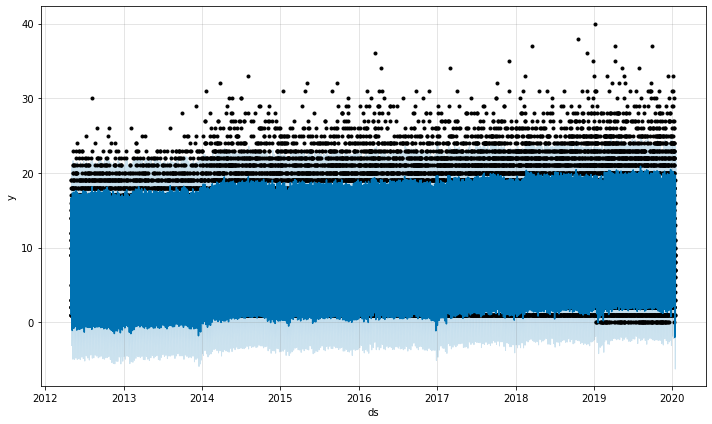

In [17]:
fig1 = m.plot(forecast)

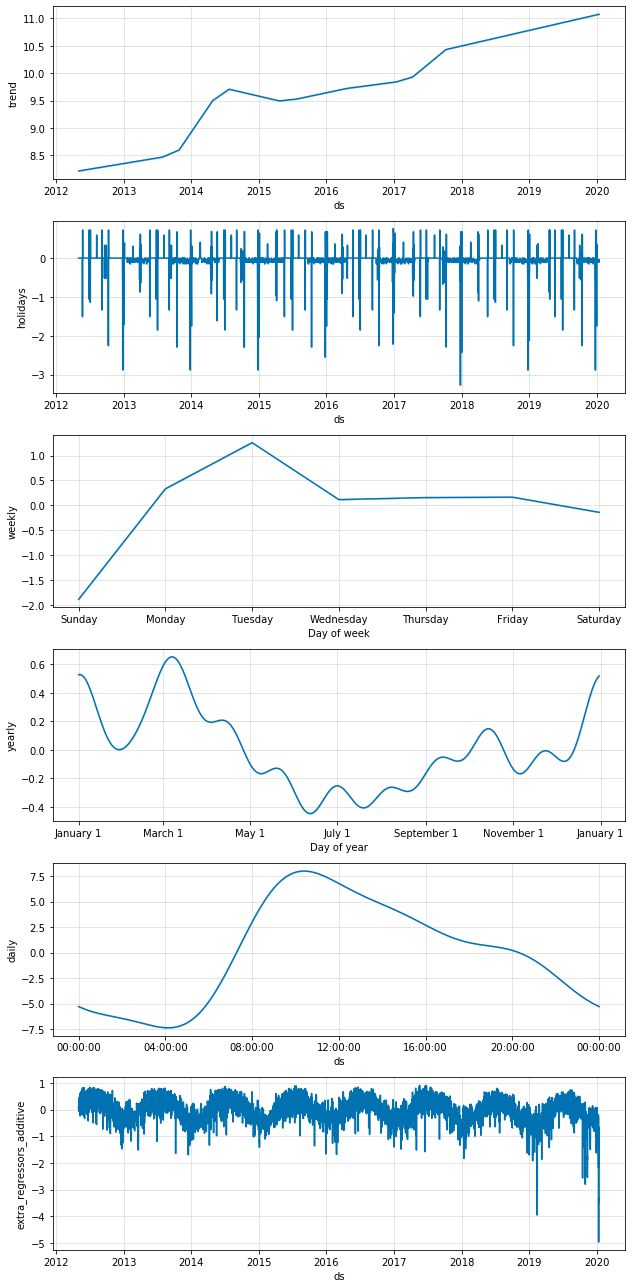

In [18]:
fig2 = m.plot_components(forecast)

In [19]:
import pickle
pkl_path = "hourly-20-01-12.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m, f)

In [20]:
# read the Prophet model object
with open(pkl_path, 'rb') as f:
    m = pickle.load(f)

In [21]:
m